---
title: "Comparison of different methods using numerical experiments"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-12-29"
file-modified: "2023-12-30"
abstract: "We perform numerical experiments to compare the power and efficiency of different methods in detecting the hidden genetics factors contributing to disease pleiotropy."

---

# Getting Setup

In [2]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [3]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

# Read Simulation Results

In [4]:
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/blockdiag"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
dscoutpkl = os.path.join("/gpfs/commons/home/sbanerjee/work/npd/lrma-dsc/dsc/results", dsc_fname + "_dscout.pkl")
dscout    = pd.read_pickle(dscoutpkl)
dscout

,DSC,simulate,simulate.n,simulate.p,simulate.k,simulate.h2,simulate.h2_shared_frac,simulate.aq,lowrankfit,matfactor,score.L_rmse,score.F_rmse,score.Z_rmse,score.L_psnr,score.F_psnr,score.Z_psnr,score.adj_MI
0,1,blockdiag,200.0,2000.0,10.0,0.2,0.5,0.6,identical,truncated_svd,0.244982,0.485097,0.005098,28.429593,24.712971,21.552452,0.018100
1,2,blockdiag,200.0,2000.0,10.0,0.2,0.5,0.6,identical,truncated_svd,0.264152,0.483567,0.005141,28.688465,24.252872,21.767697,0.015638
2,3,blockdiag,200.0,2000.0,10.0,0.2,0.5,0.6,identical,truncated_svd,0.252526,0.499034,0.005091,28.831802,23.687408,22.263407,0.654857
3,4,blockdiag,200.0,2000.0,10.0,0.2,0.5,0.6,identical,truncated_svd,0.285154,0.484862,0.005550,28.881899,24.282865,23.215231,0.561981
4,5,blockdiag,200.0,2000.0,10.0,0.2,0.5,0.6,identical,truncated_svd,0.292962,0.474069,0.005080,27.246965,24.492696,22.070442,0.024386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,8,blockdiag_aq,200.0,2000.0,10.0,0.2,0.5,0.8,identical,factorgo,0.597619,0.720961,0.002017,20.790216,21.536737,30.477673,0.010297
896,9,blockdiag_aq,200.0,2000.0,10.0,0.2,0.5,0.4,identical,factorgo,0.201241,0.400942,0.002174,30.378105,26.809769,29.938074,-0.009727
897,9,blockdiag_aq,200.0,2000.0,10.0,0.2,0.5,0.8,identical,factorgo,0.509286,0.669955,0.002038,21.469111,20.631187,28.405981,0.003175
898,10,blockdiag_aq,200.0,2000.0,10.0,0.2,0.5,0.4,identical,factorgo,0.270847,0.429577,0.002189,28.086705,25.500348,30.518931,0.022548


# Compare Methods

We use several metrics to compare the different methods. 

In [5]:
#| code-fold: false

methods = {
    "rpca" : ["rpca", "truncated_svd"],
    "nnm"  : ["nnm", "truncated_svd"],
    "nnm_sparse" : ["nnm_sparse", "truncated_svd"],
    "truncated_svd" : ["identical", "truncated_svd"],
    "factorgo" : ["identical", "factorgo"],
}
method_labels = {
    "rpca" : "RPCA-IALM",
    "nnm" : "NN-FW",
    "nnm_sparse" : "NN-Sparse-FW",
    "truncated_svd": "tSVD",
    "factorgo": "FactorGO",
}

method_colors = {
    "rpca" : '#FF6800', # Vivid Orange
    "nnm" : '#C10020', # Vivid Red
    "nnm_sparse" : '#803E75', # Strong Purple
    "truncated_svd" : '#535154', # gray
    "factorgo" : '#A6BDD7', # Very Light Blue
}

# Base parameters
simparams = {'p': 2000, 'k': 10, 'h2': 0.2, 'h2_shared_frac': 0.5, 'aq': 0.6}
score_names = {
    'L_rmse': r"$\| L - \hat{L}\|_F$",
    'F_rmse': r"$\| F - \hat{F}\|_F$",
    'Z_rmse': r"$\| LF^{T} - \hat{L}\hat{F}^{T}\|_F$",
    'adj_MI': "Adjusted Mutual Information Score",
}

# score_names = {
#     'L_psnr': r"$\| L - \hat{L}\|_F$",
#     'F_psnr': r"$\| F - \hat{F}\|_F$",
#     'Z_psnr': r"$\| LF^{T} - \hat{L}\hat{F}^{T}\|_F$",
#     'adj_MI': "Adjusted Mutual Information Score",
# }

In [6]:
def get_simulation_with_variable(df, var_name, var_values):
    condition = [(f'simulate.{k}', v) for k, v in simparams.items() if k != var_name]
    df1 = stratify_dfcols(df, condition)
    df2 = stratify_dfcols_in_list(df1, f'simulate.{var_name}', var_values)
    return df2

def get_scores_from_dataframe(df, score_name, variable_name, variable_values, 
        methods = methods):
    simdf = get_simulation_with_variable(df, variable_name, variable_values)
    scores = {key: list() for key in methods.keys()}
    for method, mlist in methods.items():
        mrows = stratify_dfcols(simdf, [('lowrankfit', mlist[0]), ('matfactor', mlist[1])])
        for value in variable_values:
            vrows = stratify_dfcol(mrows, f'simulate.{variable_name}', value)
            scores[method].append(vrows[f'score.{score_name}'].to_numpy())
    return scores

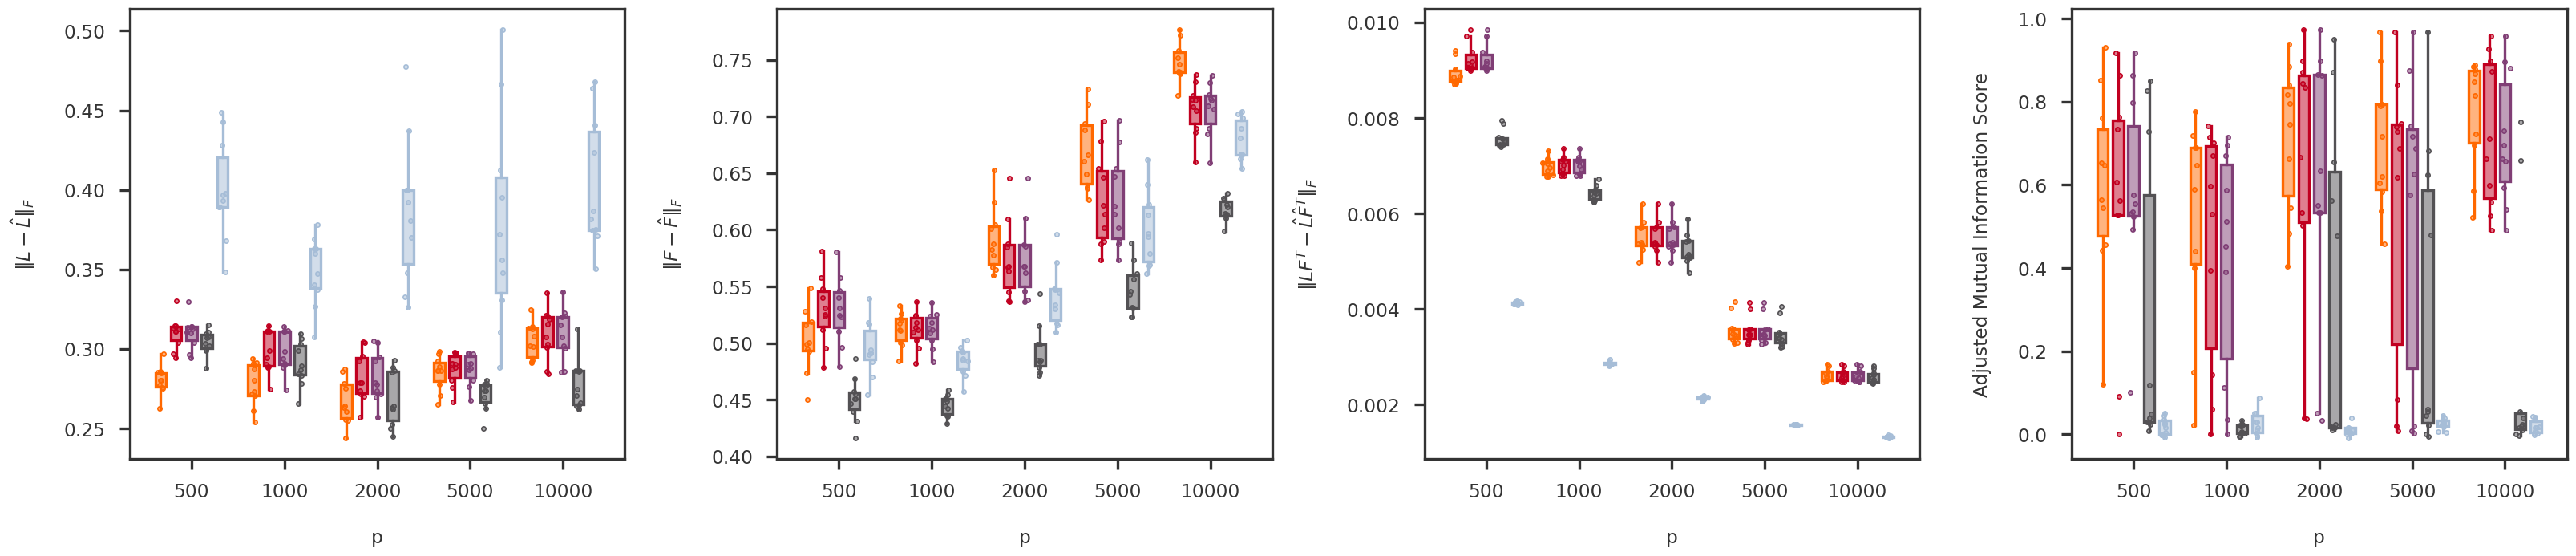

In [7]:
def random_jitter(xvals, yvals, d = 0.1):
    xjitter = [x + np.random.randn(len(y)) * d for x, y in zip(xvals, yvals)]
    return xjitter

def boxplot_scores(variable, variable_values, 
        methods = methods, score_names = score_names,
        dscout = dscout, method_colors = method_colors):
    
    nmethods = len(methods)
    nvariables = len(variable_values)
    nscores = len(score_names)
    
    figh = 6
    figw = (nscores * figh) + (nscores - 1)
    fig = plt.figure(figsize = (figw, figh))
    axs = [fig.add_subplot(1, nscores, x+1) for x in range(nscores)]
    boxs = {x: None for x in methods.keys()}
    
    for i, (score_name, score_label) in enumerate(score_names.items()):
        scores = get_scores_from_dataframe(dscout, score_name, variable, variable_values)
        for j, mkey in enumerate(methods.keys()):
            boxcolor = method_colors[mkey]
            boxface = f'#{boxcolor[1:]}80'
            medianprops = dict(linewidth=0, color = boxcolor)
            whiskerprops = dict(linewidth=2, color = boxcolor)
            boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
            flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

            xpos = [x * (nmethods + 1) + j for x in range(nvariables)]
            boxs[mkey] = axs[i].boxplot(scores[mkey], positions = xpos,
                showcaps = False, showfliers = False,
                widths = 0.7, patch_artist = True, notch = False,
                flierprops = flierprops, boxprops = boxprops,
                medianprops = medianprops, whiskerprops = whiskerprops)
            
            axs[i].scatter(random_jitter(xpos, scores[mkey]), scores[mkey], 
                           edgecolor = boxcolor, facecolor = boxface, linewidths = 1, 
                           s = 10)

        xcenter = [x * (nmethods + 1) + (nmethods - 1) / 2 for x in range(nvariables)]
        axs[i].set_xticks(xcenter)
        axs[i].set_xticklabels(variable_values)
        axs[i].set_xlabel(variable)
        axs[i].set_ylabel(score_label)
        xlim_low = 0 - (nvariables - 1) / 2
        #xlim_high = (nvariables - 1) * (nmethods + 1) + (nmethods - 1) + (nvariables - 1) / 2
        xlim_high = (nmethods + 1.5) * nvariables - 2.5
        axs[i].set_xlim( xlim_low, xlim_high )

    plt.tight_layout()
    return axs, boxs

variable = 'p'
variable_values = [500, 1000, 2000, 5000, 10000]

axs, boxs = boxplot_scores(variable, variable_values)
plt.show()

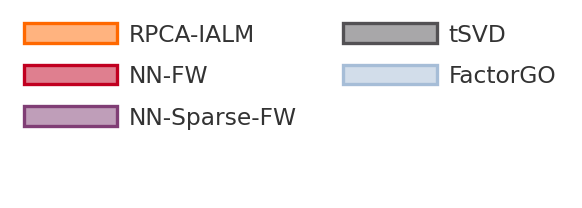

In [8]:
fig = plt.figure(figsize = (6, 2))
ax1 = fig.add_subplot(111)
handles = [boxs[mkey]["boxes"][0] for mkey in methods.keys()]
labels = [method_labels[mkey] for mkey in methods.keys()]
ax1.legend(handles = handles, labels = labels, loc = 'upper left', frameon = False, handlelength = 4, ncol = 2)

for side, border in ax1.spines.items():
    border.set_visible(False)
ax1.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)


plt.show()

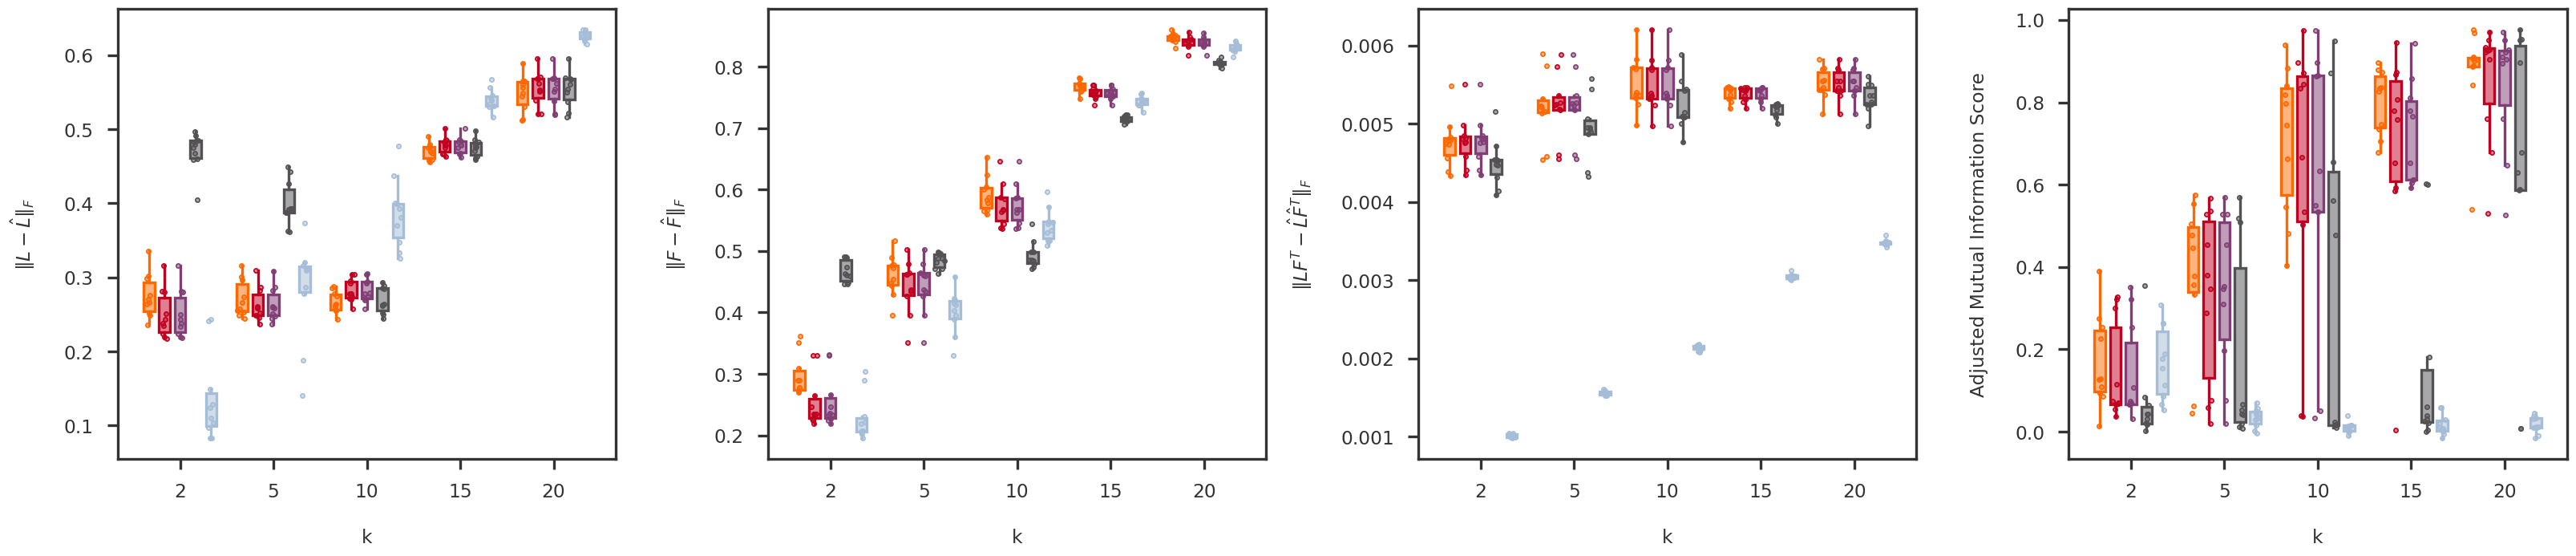

In [9]:
variable = 'k'
variable_values = [2,5,10,15,20]
boxplot_scores(variable, variable_values)
plt.show()

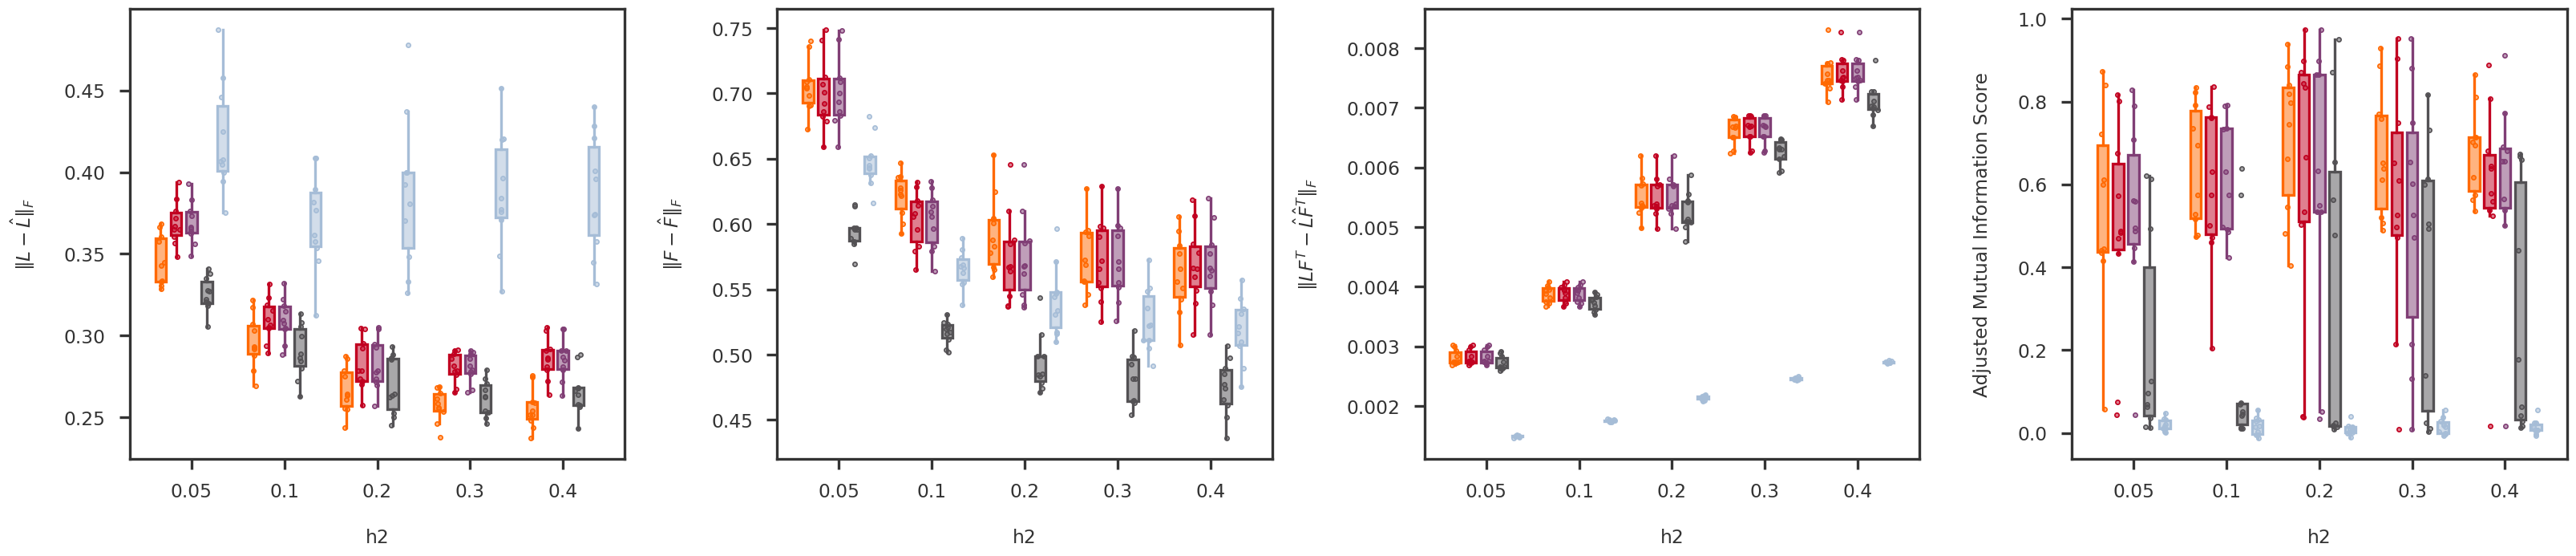

In [10]:
variable = 'h2'
variable_values = [0.05, 0.1, 0.2, 0.3, 0.4]
boxplot_scores(variable, variable_values)
plt.show()

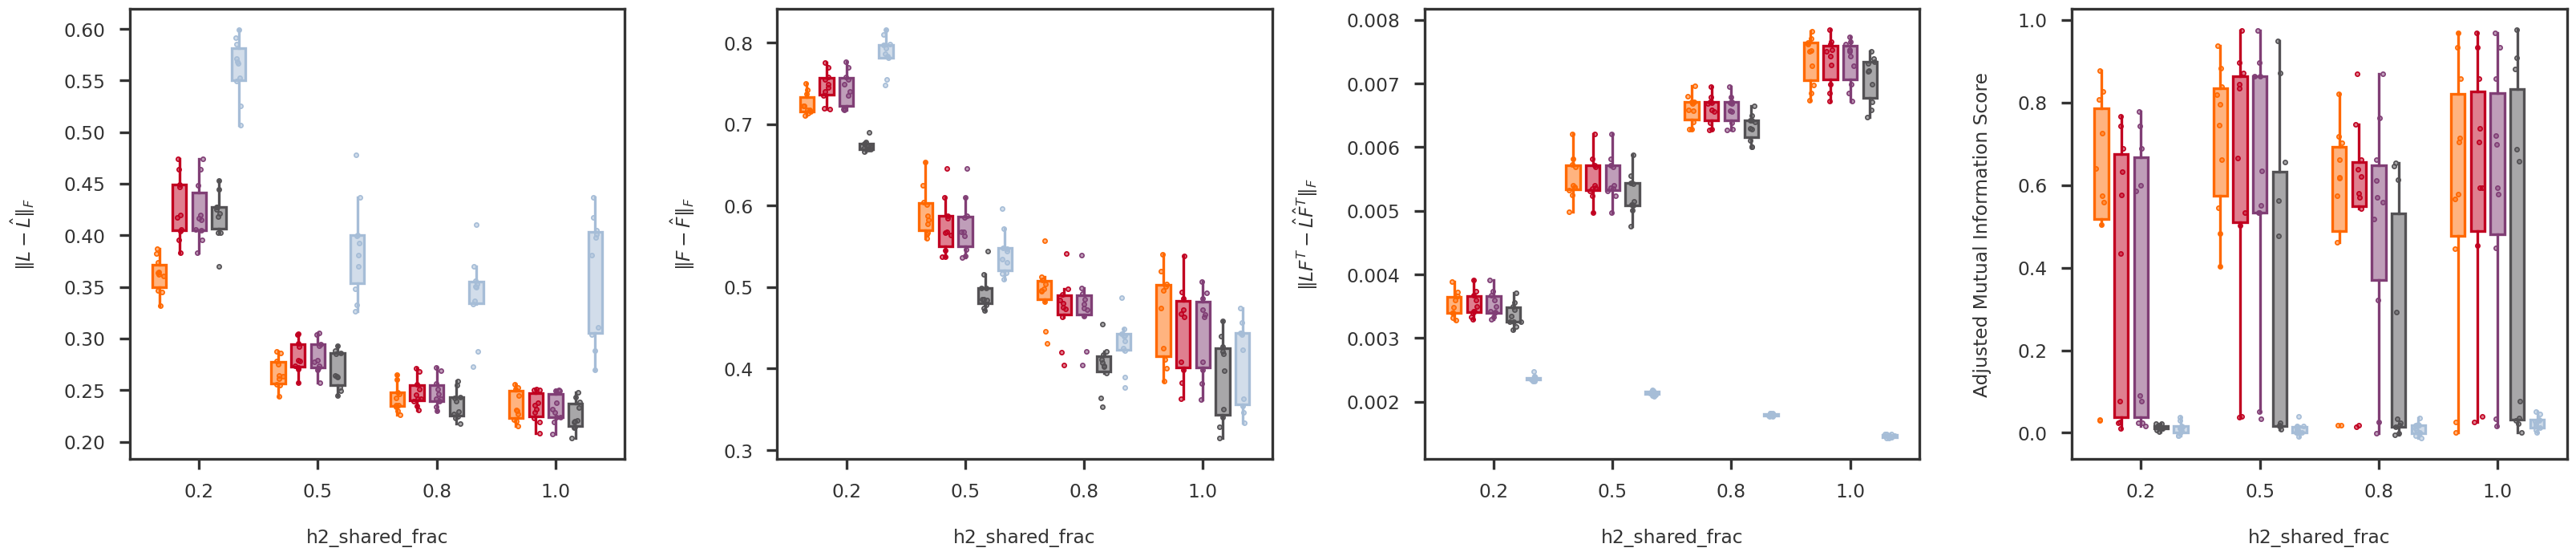

In [11]:
variable = 'h2_shared_frac'
variable_values = [0.2, 0.5, 0.8, 1.0]
boxplot_scores(variable, variable_values)
plt.show()

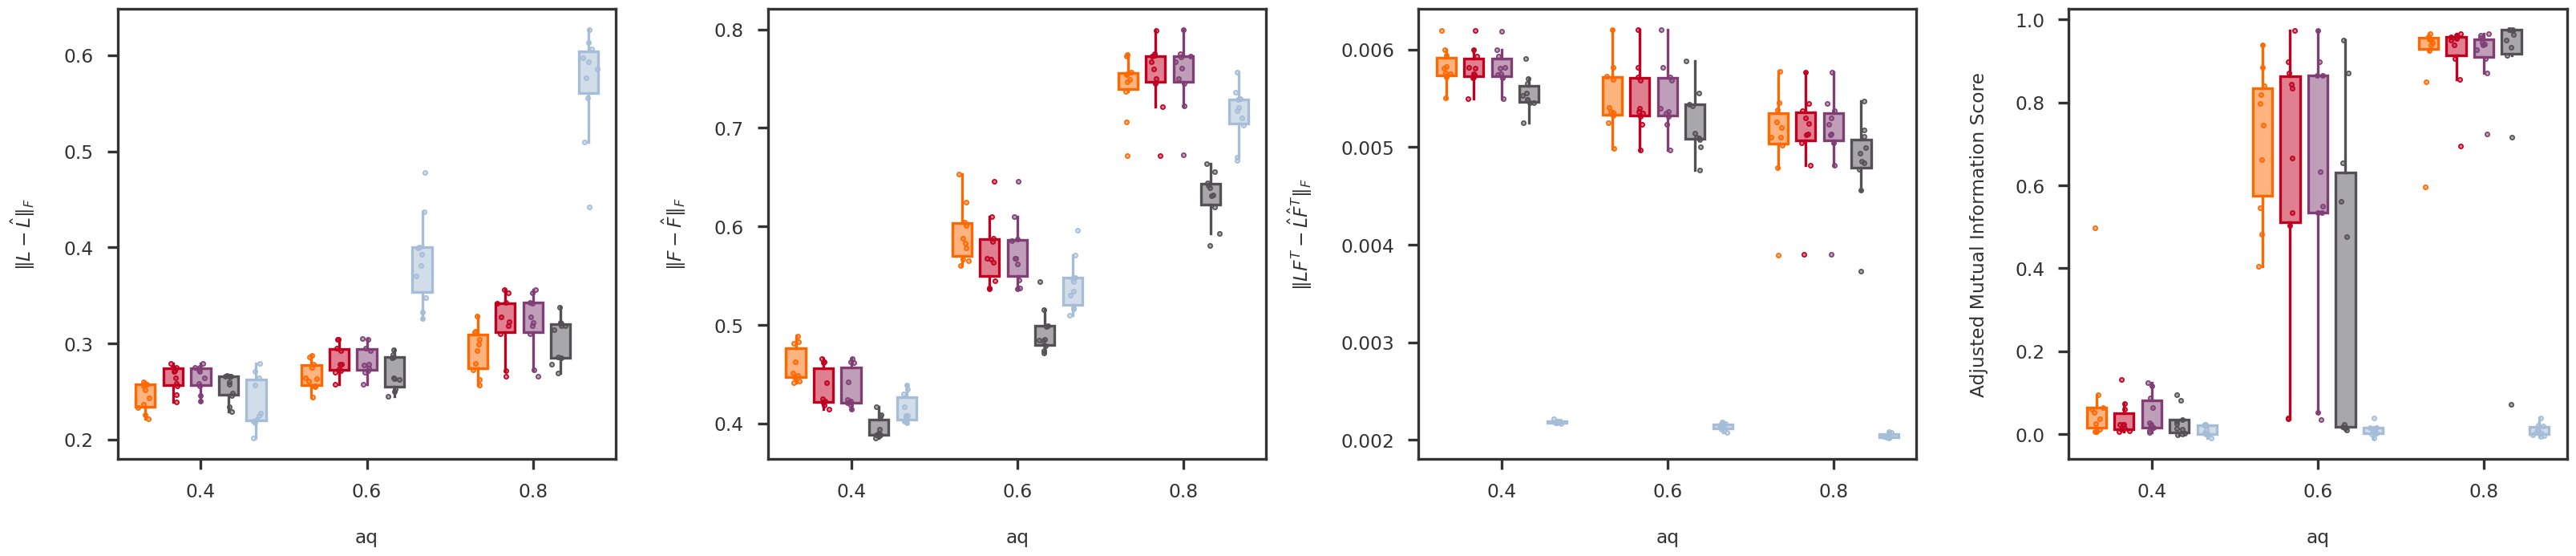

In [12]:
variable = 'aq'
variable_values = [0.4, 0.6, 0.8]
boxplot_scores(variable, variable_values)
plt.show()

# PSNR

Instead of the Frobenius norm, we can also use the Peak Signal-to-Noise Ratio (PSNR) for comparing the methods.

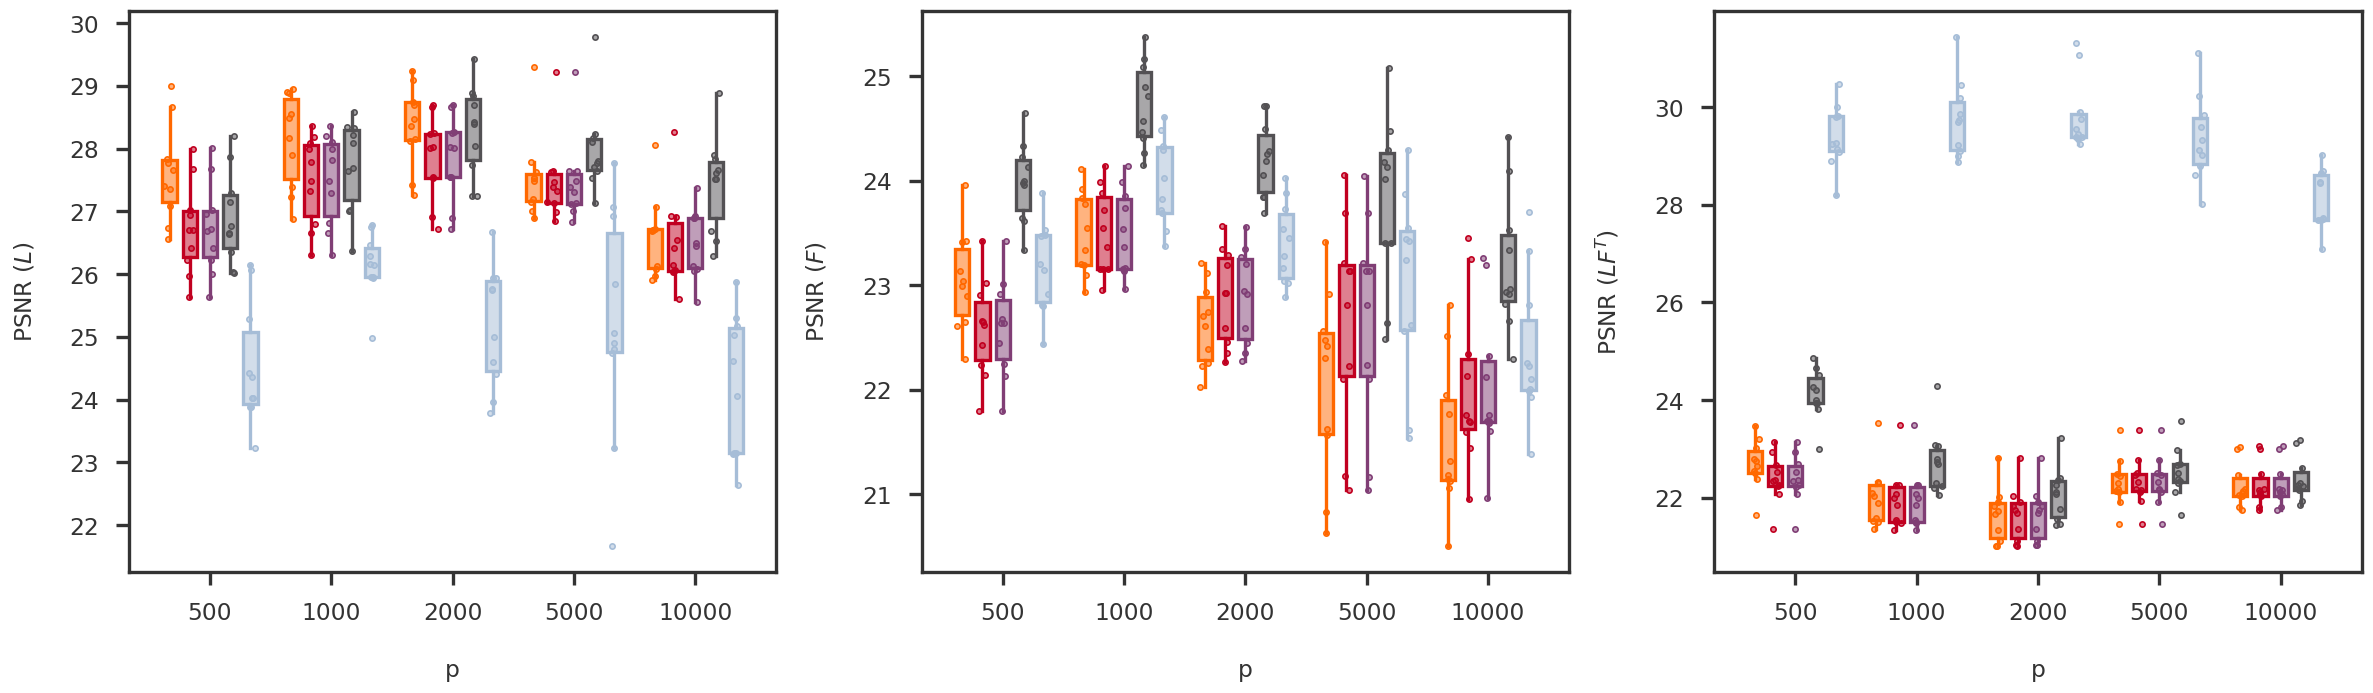

In [14]:
psnr_score_names = {
    'L_psnr': r"PSNR ($L$)",
    'F_psnr': r"PSNR ($F$)",
    'Z_psnr': r"PSNR ($LF^T$)",
}

variable = 'p'
variable_values = [500, 1000, 2000, 5000, 10000]

axs, boxs = boxplot_scores(variable, variable_values, score_names = psnr_score_names)
plt.show()